# Intro to Regression

We're going to go through a few regression exercises that will help you better see how regression might work in action in Python.  


## Setup
Try running the following imports and check that they all import successfully.  If they do not, the commands for the installs are given below.  If necessary, at a command line window use `pip` to install the ones that are failing for you and then retry the imports.

In [2]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt

%matplotlib inline

/Users/tdeburca/Library/Python/2.7/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Installations (if necessary)
<pre><code>pip install pandas</code></pre>
<pre><code>pip install numpy</code></pre>
<pre><code>pip install statsmodels</code></pre>
<pre><code>pip install seaborn</code></pre>
<pre><code>pip install scikit-learn</code></pre>

## Survey Data
We will use this [simple survey data](http://www.ats.ucla.edu/stat/examples/chp/p054.txt) to demonstrate a few basic features of ***statsmodels*** and ***seaborn*** and how they might be used in a data science workflow for regression.

The dataset is simply the results of a survey where the question responses are all numeric.  This leads to 6 numeric independent variable (predictor) fields and 1 numeric dependent variable (response) field.  The predictors are labeled ***X<sub>i</sub>*** and the response is labeled ***Y***.

Let's load the dataset in using ***pandas*** and take a look at it.  Here we use [***pandas.read_table***](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) to load the data.

In [3]:
# Load the data in
# df = pd.read_table('http://www.ats.ucla.edu/stat/examples/chp/p054.txt')
df = pd.read_table('https://stats.idre.ucla.edu/wp-content/uploads/2016/02/p054.txt')

# Take a look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
Y      30 non-null int64
X1     30 non-null int64
X2     30 non-null int64
X3     30 non-null int64
X4     30 non-null int64
X5     30 non-null int64
X6     30 non-null int64
dtypes: int64(7)
memory usage: 1.7 KB


In [4]:
# Take a look at the first few rows
df.head()

Y   X1   X2   X3   X4   X5   X6 
0  43   51   30   39   61   92   45
1  63   64   51   54   63   73   47
2  71   70   68   69   76   86   48
3  61   63   45   47   54   84   35
4  81   78   56   66   71   83   47

If we look at the column names, we'll notice we have the trailing whitespace problem again.

In [5]:
df.columns

Index([u'Y ', u'X1 ', u'X2 ', u'X3 ', u'X4 ', u'X5 ', u'X6 '], dtype='object')

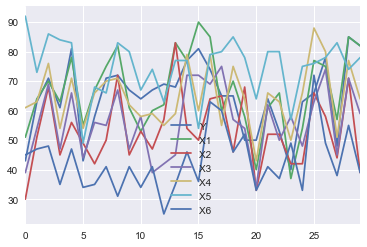

We can remove this by calling map on the columns list and stripping the whitespace with strip.  The ***map*** function is applied to Series objects, whereas the ***apply*** and ***applymap*** functions are called on Dataframes.

In [5]:
df.columns = df.columns.map(str.strip)
df.columns

Index([u'Y', u'X1', u'X2', u'X3', u'X4', u'X5', u'X6'], dtype='object')

In [6]:
# How many rows and columns does the dataset have?
df.shape

(30, 7)

### Visualizing with Seaborn
We see that the data has 30 responses with 7 fields (6 independent, 1 dependent) each.  Let's use pandas to check out the correlations between the different variables.

In [7]:
# View the correlations
df.corr()

Y        X1        X2        X3        X4        X5        X6
Y   1.000000  0.825418  0.426117  0.623678  0.590139  0.156439  0.155086
X1  0.825418  1.000000  0.558288  0.596736  0.669197  0.187714  0.224580
X2  0.426117  0.558288  1.000000  0.493331  0.445478  0.147233  0.343293
X3  0.623678  0.596736  0.493331  1.000000  0.640314  0.115965  0.531620
X4  0.590139  0.669197  0.445478  0.640314  1.000000  0.376883  0.574186
X5  0.156439  0.187714  0.147233  0.115965  0.376883  1.000000  0.283343
X6  0.155086  0.224580  0.343293  0.531620  0.574186  0.283343  1.000000

#### Correlation and Multicollinearity
We notice that some of the variables are highly correlated.  This is something we might want to take into consideration later.  When 2 predictor variables are highly correlated this is called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and it is something we want to watch out for as it can destabilize our model.  In the extreme case, when 2 predictors are perfectly correlated then there is absolutely nothing gained by making both variables part of our regression.

The other takeaway from this table is that some of our predictors are highly correlated with our ***target variable Y***.  This is a good thing, it means that these are the variables that we most likely want to include as part of our model as they explain a large amount of the variance in the target variable (correlation=R, variance_explained=R<sup>2</sup>).

Let's try to visualize these correlations all together by using the [***seaborn pairplot***](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html) function.  What do you notice?

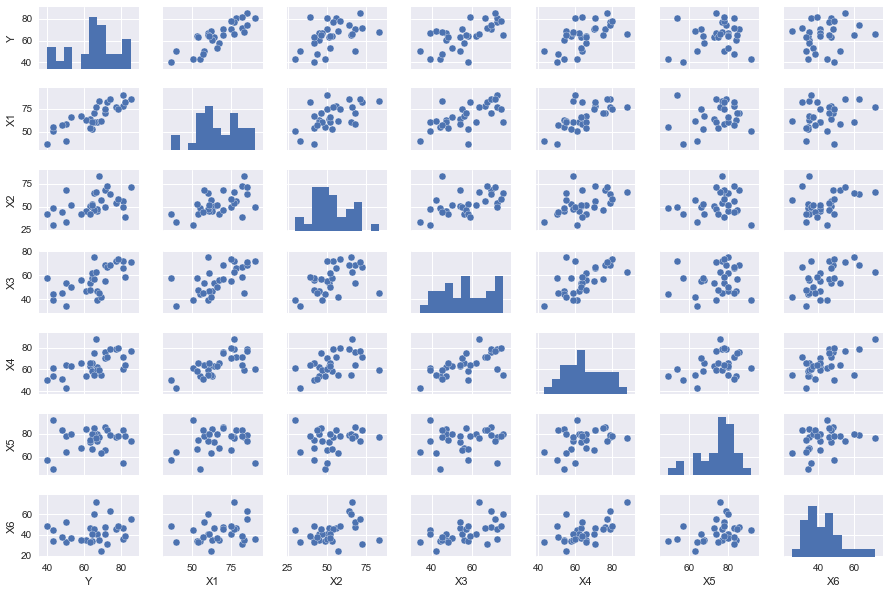

In [9]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df, size = 1.2, aspect=1.5)

### Ordinary Least Squares Regression with Statsmodels
Now that we have a feel for our data, let's jump right in and try a basic regression model.  

#### Statsmodels
We are going to use the [**`statsmodels`**](http://statsmodels.sourceforge.net/) library first.  `statsmodels` is a Python package for implementing [**linear models**](https://en.wikipedia.org/wiki/Linear_model), of which **Linear Regression** is one.  It has a bunch of nice features for evaluating and executing such models.  Essentially, a linear model is one that is a **linear function of the parameters**.  For Linear Regression, this means the parameter $\beta$ (note that here $\beta$ is a **vector** of parameters, which includes $\beta_0$, $\beta_1$, $\beta_2$, etc).  We'll discuss linear models generally later but for  now just accept that Linear Regression is one of these.

#### Modeling with Statsmodels
There are 2 main ways you can generate models with stats models:
- Via the `statsmodels.api` package
- Via the `statsmodels.formula.api` package

For both approaches, you'll need somewhere to use the [R formula](http://science.nature.nps.gov/im/datamgmt/statistics/r/formulas/) styles formulas for defining the relationship between target variable and feature variables in your model.  ***Statsmodels*** uses [***patsy***](http://patsy.readthedocs.org/en/latest/) to convert this syntax into the proper data matrices for input into its linear models under the covers.  There are a variety of interactions and functions of variables that you can incorporate with this syntax, so feel free to check out the docs.

Here we'll just start by defining a regression model that takes as its inputs each of the 6 predictor variables.  The other parameter of course is the data that the model is to be built from, our pandas dataframe.

This first model fitting is done for you, it fits a multiple linear regression model of the following form (notice the use of [MathJax](https://www.mathjax.org/) for rendering such lovely math equations in markdown):

$$
Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_4 + \beta_5X_5 + \beta_6X_6
$$

##### `statsmodels.api`
To use this method, you need to generate a **matrix** of **features**, **`X`** and a **vector** of **targets**, **`y`** where each row represents a single **observation**.  In statsmodels, you can do this with a call to **`patsy.dmatrices`**:


In [8]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=df, return_type="dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Thu, 27 Jul 2017   Prob (F-statistic):           1.24e-05
Time:                        18:24:01   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.7871     11.589      0.931      0.362       -13.187    34.761
X1             0.6132      0.161      3.809      0.001         0.280     0.946
X2            -0.0731      0.136     -0.538      0.596        -0.354     0.208
X3             0.3203      0.169      1.901      0.070        -0.028     0.669
X4             0.0817      0.221      0.369      0.715        -0.376     0.540
X5             0.0384      0.147      0.261      0.796        -0.266     0.342
X6            -0.2171      0.178     -1.218      0.236        -0.586     0.152
==============================================================================
Omnibus:                        2.386   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.255
Skew:                          -0.081   Prob(JB):                        0.534
Kurtosis:                       2.011   Cond. No.                     1.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### `statsmodels.formula.api`
The formula approach handles the creation of the `X` and `y` matrices internally, so all you have to do is supply the R formula for your model when you create your `ols` object.  

**NOTE:** We'll use this for the remainder of these exercises, but many people like to stick with the `dmatrices` and `X`, `y` matrix creation approach because that is the way `sklearn` works (see later).  Notice that here we've built the same model and it's deterministic, so the results are the same.

In [9]:
# Define the model
lm1 = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=df)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Thu, 27 Jul 2017   Prob (F-statistic):           1.24e-05
Time:                        18:24:10   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.7871     11.589      0.931      0.362       -13.187    34.761
X1             0.6132      0.161      3.809      0.001         0.280     0.946
X2            -0.0731      0.136     -0.538      0.596        -0.354     0.208
X3             0.3203      0.169      1.901      0.070        -0.028     0.669
X4             0.0817      0.221      0.369      0.715        -0.376     0.540
X5             0.0384      0.147      0.261      0.796        -0.266     0.342
X6            -0.2171      0.178     -1.218      0.236        -0.586     0.152
==============================================================================
Omnibus:                        2.386   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.255
Skew:                          -0.081   Prob(JB):                        0.534
Kurtosis:                       2.011   Cond. No.                     1.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Regression Statistics
From this we get a handful of useful statistics describing our regression.  A quick google search on any should yield details for those interested.  We will focus on the ***R<sup>2</sup>*** values and the middle table here.

***R<sup>2</sup>*** is the square of the correlation coefficient and represents the estimated percentage of the variance in our target variable ***Y*** that can be explained by our regression model.  ***Adjusted R<sup>2</sup>*** also penalizes for things such as large coefficients and extra variables to try and limit ***overfitting*** so it is often a better measure of model efficacy.  We will use that here.

The middle table provides the **coefficients** that are regression has found, along with the **standard error** for each coefficient.  This defines our model, aka these are the model parameters that our algorithm was seeking to determine.  

The **t-scores** are values that the coefficients score in the [Student's T Distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) and the **P(|t|)** field represents the probability of finding such a t-score if the actual value of the coefficient were 0.  In other words, if we had a coefficient whose true value should be 0 (aka the predictor has no impact on the response) then this P-value is the probability of finding such a coefficient value in our regression by random chance.  In essence, it measures our degree of belief that the coefficient for each variable should be zero.  Thus, the lowest P-values represent the most likely predictors to be impacting the response.

Putting it all together, the final column returns a **95% Confidence Interval** for the value of each coefficient.

Given these stats, lets remove the highest 3 P-values from our regression model, from ***X<sub>2</sub>***, ***X<sub>4</sub>***, and ***X<sub>5</sub>*** and see how our model performs now:

In [10]:
# STUDENT SECTION
# Define the model removing X2, X4, and X5
lm2 = smf.ols('Y ~ X1 + X3 + X6', data=df)
# Fit the model
fit2 = lm2.fit()
# Check out the results
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     22.92
Date:                Thu, 27 Jul 2017   Prob (F-statistic):           1.81e-07
Time:                        18:24:16   Log-Likelihood:                -97.638
No. Observations:                  30   AIC:                             203.3
Df Residuals:                      26   BIC:                             208.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.5777      7.544      1.800      0.084        -1.929    29.084
X1             0.6227      0.118      5.271      0.000         0.380     0.866
X3             0.3124      0.154      2.026      0.053        -0.005     0.629
X6            -0.1870      0.145     -1.291      0.208        -0.485     0.111
==============================================================================
Omnibus:                        2.856   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                1.394
Skew:                          -0.121   Prob(JB):                        0.498
Kurtosis:                       1.972   Cond. No.                         605.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You should see our **Adjusted R<sup>2</sup>** has increased, and our P-values are lower so we likely have a better model.  Let's just try removing ***X<sub>6</sub>*** to see if that might improve our model a little bit more.

In [11]:
# STUDENT SECTION
# Define the model removing X6 this time
lm3 = smf.ols('Y ~ X1 + X3', data=df)
# Fit the model
fit3 = lm3.fit()
# Check out the results
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     32.74
Date:                Thu, 27 Jul 2017   Prob (F-statistic):           6.06e-08
Time:                        18:24:22   Log-Likelihood:                -98.569
No. Observations:                  30   AIC:                             203.1
Df Residuals:                      27   BIC:                             207.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      9.8709      7.061      1.398      0.174        -4.618    24.359
X1             0.6435      0.118      5.432      0.000         0.400     0.887
X3             0.2112      0.134      1.571      0.128        -0.065     0.487
==============================================================================
Omnibus:                        6.448   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                1.959
Skew:                          -0.041   Prob(JB):                        0.375
Kurtosis:                       1.751   Cond. No.                         503.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nope, both **R<sup>2</sup>** coefficients decreased so lets stick with the 2nd model.

### Plotting Residuals
Before we call it a day with this model and dataset, let's take a quick look at a plot of our residuals *(actual value - predicted value)* with this model.  We do this because in a good model we essentially want our errors to be random.  If our residuals look systematic (e.g. missing high for one range and low for another) then we probably are missing the actual functional dependency underlying the data (perhaps it's not really linear).

Take a look [here]([a bad residue plot](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit) for an example of a bad residual plot.

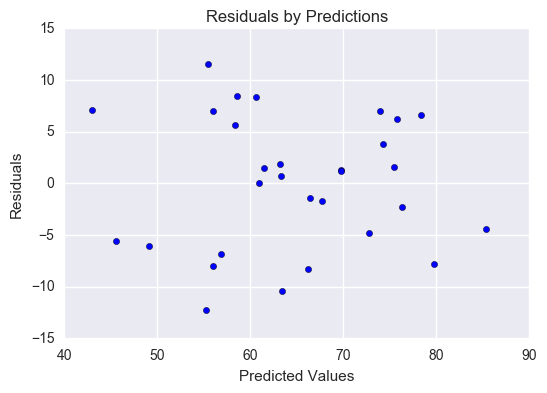

In [13]:
# Use statsmodels to plot the residuals
plt.scatter(fit2.fittedvalues, fit2.resid) #plot residuals against predictions
plt.title('Residuals by Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Above - you want residuals to be normally distributed around 0 (on the y-axis). You want the variance in the residuals to be the same all along the x-axis. In other words, you want to have the same amount of "spread" all along the x-axis. For a picture of NOT this, see [here](http://3.bp.blogspot.com/-YzxZBuB83aI/UJXjFIwKidI/AAAAAAAAE-Y/R2RvUVR07So/s1600/2012-04-heteroskedasticity_modelling2.png).

Below - you can also create a QQ plot. Basically, if your residuals are normally distributed, they will lie along the red line. If your residuals deviate from a normal distribution at some point, you will see that your residuals are off of the red line at certain points.

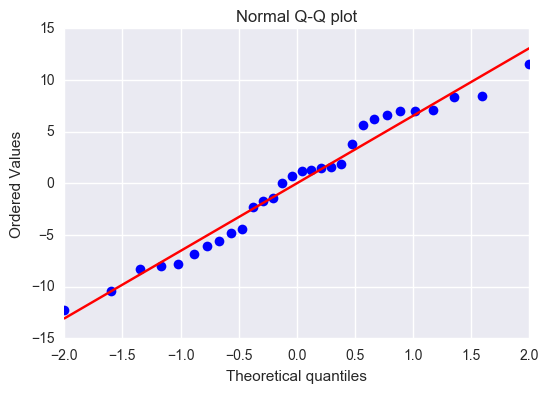

In [14]:
import scipy.stats as stats

stats.probplot(fit2.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

Nope this looks pretty random to me!  So let's move on to some more interesting modeling functions with sklearn!

## Exercises: Car Price Predictor Dataset
For these exercises we'll be exploring the auto data available [here](https://archive.ics.uci.edu/ml/datasets/Automobile).  The goal is to be able to predict auto price from the 

#### Data Exploration
##### Read the data in
Use pandas `read_csv()` to load the data into a dataframe and then call `head()` to make sure everything looks good.

In [18]:
# read in the car dataset
df=pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data',header=None)

columns= ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style',
          'drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type',
          'num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm',
          'city-mpg','highway-mpg','price']
df.columns=columns
# Use head to view the first few rows
df.head()

symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
0  convertible          rwd           front        88.6  ...            130   
1  convertible          rwd           front        88.6  ...            130   
2    hatchback          rwd           front        94.5  ...            152   
3        sedan          fwd           front        99.8  ...            109   
4        sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compression-ratio horsepower  peak-rpm city-mpg  \
0         mpfi  3.47    2.68               9.0        111      5000       21   
1         mpfi  3.47    2.68               9.0        111      5000       21   
2         mpfi  2.68    3.47               9.0        154      5000       19   
3         mpfi  3.19    3.40              10.0        102      5500       24   
4         mpfi  3.19    3.40               8.0        115      5500       18   

  highway-mpg  price  
0          27  13495  
1          27  16500  
2          26  16500  
3          30  13950  
4          22  17450  

[5 rows x 26 columns]

Use [`shape`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html#pandas.DataFrame.shape) to check out how many rows and columns the dataframe has.

In [28]:
# STUDENT SECTION
# How many rows and columns do we have? 
print(df.shape)

(205, 26)


Use [`info()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html#pandas.DataFrame.info) to get a summary of the dataframe and its datatypes

In [29]:
# STUDENT SECTION
# Let's examine the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

**Lets keep numeric data ** 
- Create a list of columns to keep
- Select out only those columns from the dataframe and reassign the dataframe to that selection
- Use `head()` & `info()` to make sure everything worked as expected

In [30]:
# STUDENT SECTION
# Create a list of columns to keep

subset=['wheel-base','length','width','height','curb-weight',
        'engine-size','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
cars=df[subset]

cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 14 columns):
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-size          205 non-null int64
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-null object
peak-rpm             205 non-null object
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                205 non-null object
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ KB


It looks like some of our features (even our targe feature :'price') is listed as an object.    
Run cars.head(10), and we will see why!  

In [31]:
cars.head(10)


wheel-base  length  width  height  curb-weight  engine-size  bore stroke  \
0        88.6   168.8   64.1    48.8         2548          130  3.47   2.68   
1        88.6   168.8   64.1    48.8         2548          130  3.47   2.68   
2        94.5   171.2   65.5    52.4         2823          152  2.68   3.47   
3        99.8   176.6   66.2    54.3         2337          109  3.19   3.40   
4        99.4   176.6   66.4    54.3         2824          136  3.19   3.40   
5        99.8   177.3   66.3    53.1         2507          136  3.19   3.40   
6       105.8   192.7   71.4    55.7         2844          136  3.19   3.40   
7       105.8   192.7   71.4    55.7         2954          136  3.19   3.40   
8       105.8   192.7   71.4    55.9         3086          131  3.13   3.40   
9        99.5   178.2   67.9    52.0         3053          131  3.13   3.40   

   compression-ratio horsepower peak-rpm  city-mpg  highway-mpg  price  
0                9.0        111     5000        21           27  13495  
1                9.0        111     5000        21           27  16500  
2                9.0        154     5000        19           26  16500  
3               10.0        102     5500        24           30  13950  
4                8.0        115     5500        18           22  17450  
5                8.5        110     5500        19           25  15250  
6                8.5        110     5500        19           25  17710  
7                8.5        110     5500        19           25  18920  
8                8.3        140     5500        17           20  23875  
9                7.0        160     5500        16           22      ?

In [32]:
# STUDENT SECTION : replace "?" data in order to turn our features into numerics

cols=['bore','stroke','horsepower','peak-rpm','price']

cars.loc[:,cols]=cars[cols].replace('?',np.nan)
cars.loc[:,cols]=cars[cols].astype(float)

cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 14 columns):
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-size          205 non-null int64
bore                 201 non-null float64
stroke               201 non-null float64
compression-ratio    205 non-null float64
horsepower           203 non-null float64
peak-rpm             203 non-null float64
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                201 non-null float64
dtypes: float64(10), int64(4)
memory usage: 22.5 KB


We can see from the above output, that only a few entries where unknown in the first place.   
To keep things simple for now, lets just go ahead and drop the entries that were unknown: 


In [33]:
cars=cars.dropna()
len(cars)

195

Before we begin modeling, use the [`corr()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html#pandas.DataFrame.corr) function to get a feel for the correlations among the different variables, especially with regard to 'price'.

In [34]:
cars.corr()

wheel-base    length     width    height  curb-weight  \
wheel-base           1.000000  0.879222  0.819009  0.592500     0.782720   
length               0.879222  1.000000  0.858084  0.496218     0.881665   
width                0.819009  0.858084  1.000000  0.315834     0.867315   
height               0.592500  0.496218  0.315834  1.000000     0.307732   
curb-weight          0.782720  0.881665  0.867315  0.307732     1.000000   
engine-size          0.569704  0.687479  0.740320  0.031286     0.857573   
bore                 0.498228  0.609437  0.544311  0.189283     0.645806   
stroke               0.171722  0.118664  0.186432 -0.055525     0.172785   
compression-ratio    0.247730  0.160172  0.190997  0.261160     0.155382   
horsepower           0.375541  0.583813  0.616779 -0.084412     0.760285   
peak-rpm            -0.352331 -0.280986 -0.251627 -0.264078    -0.278944   
city-mpg            -0.499126 -0.689660 -0.647099 -0.102367    -0.772171   
highway-mpg         -0.566355 -0.719324 -0.692220 -0.151188    -0.812710   
price                0.585793  0.695331  0.754273  0.138291     0.835729   

                   engine-size      bore    stroke  compression-ratio  \
wheel-base            0.569704  0.498228  0.171722           0.247730   
length                0.687479  0.609437  0.118664           0.160172   
width                 0.740320  0.544311  0.186432           0.190997   
height                0.031286  0.189283 -0.055525           0.261160   
curb-weight           0.857573  0.645806  0.172785           0.155382   
engine-size           1.000000  0.583091  0.211989           0.024617   
bore                  0.583091  1.000000 -0.066793           0.003057   
stroke                0.211989 -0.066793  1.000000           0.199882   
compression-ratio     0.024617  0.003057  0.199882           1.000000   
horsepower            0.842691  0.568527  0.100040          -0.214401   
peak-rpm             -0.219008 -0.277662 -0.068300          -0.444582   
city-mpg             -0.710624 -0.591950 -0.027641           0.331413   
highway-mpg          -0.732138 -0.600040 -0.036453           0.267941   
price                 0.888942  0.546873  0.093746           0.069500   

                   horsepower  peak-rpm  city-mpg  highway-mpg     price  
wheel-base           0.375541 -0.352331 -0.499126    -0.566355  0.585793  
length               0.583813 -0.280986 -0.689660    -0.719324  0.695331  
width                0.616779 -0.251627 -0.647099    -0.692220  0.754273  
height              -0.084412 -0.264078 -0.102367    -0.151188  0.138291  
curb-weight          0.760285 -0.278944 -0.772171    -0.812710  0.835729  
engine-size          0.842691 -0.219008 -0.710624    -0.732138  0.888942  
bore                 0.568527 -0.277662 -0.591950    -0.600040  0.546873  
stroke               0.100040 -0.068300 -0.027641    -0.036453  0.093746  
compression-ratio   -0.214401 -0.444582  0.331413     0.267941  0.069500  
horsepower           1.000000  0.105654 -0.834117    -0.812917  0.811027  
peak-rpm             0.105654  1.000000 -0.069493    -0.016950 -0.104333  
city-mpg            -0.834117 -0.069493  1.000000     0.972350 -0.702685  
highway-mpg         -0.812917 -0.016950  0.972350     1.000000 -0.715590  
price                0.811027 -0.104333 -0.702685    -0.715590  1.000000

Take a look at only the 'price' column of the correlations and order it in descending order wih [`sort_values()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html#pandas.DataFrame.sort_values)

In [35]:
# STUDENT SECTION
# Get the correlations with 'price' sorted in descending order
cars.corr()['price'].sort_values(ascending=False)

price                1.000000
engine-size          0.888942
curb-weight          0.835729
horsepower           0.811027
width                0.754273
length               0.695331
wheel-base           0.585793
bore                 0.546873
height               0.138291
stroke               0.093746
compression-ratio    0.069500
peak-rpm            -0.104333
city-mpg            -0.702685
highway-mpg         -0.715590
Name: price, dtype: float64

You should now have a better feel for which variables might be most valuable for your model.
Q :  Do correlations provide the 'entire picture' of what is happening with our model? 
A:  Nope. It can give us an idea : but corrs will only provide the relationship with the response variable (all other factors being held constant) 

Now use ***seaborn's*** `pairplot()` function to visualize these correlations for the variables.  What do you think of our distributions?

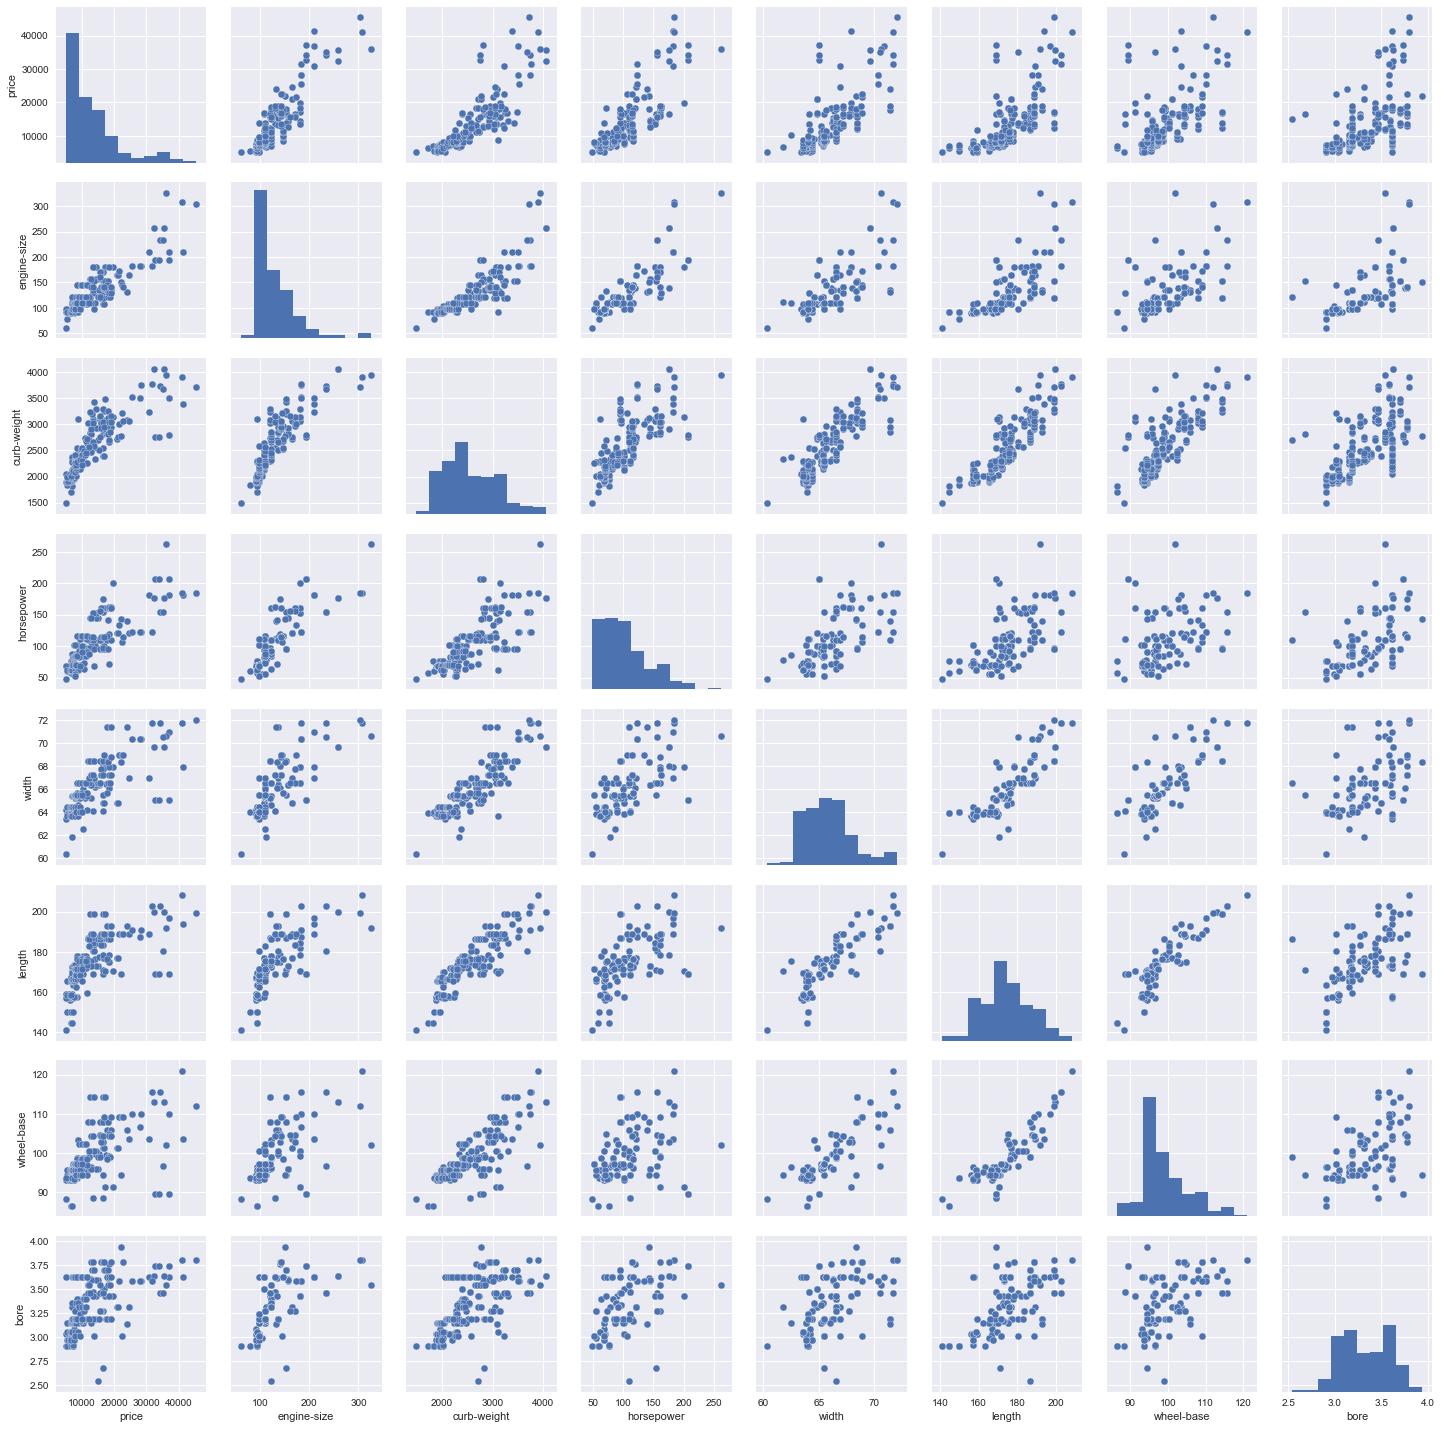

In [36]:
# STUDENT SECTION
#Let's try visualizing some of these pairwise correlations with seaborn
sns.pairplot(cars[['price','engine-size', 'curb-weight', 'horsepower', 'width', 'length', 'wheel-base','bore']])

#### Modeling with statsmodels
Let's try some exploration with statsmodels.  As a first model, try creating an ordinary least squares model with statsmodels by incorporating all of the variables that had at least a .10 absolute value of correlation with cnt above 
- Create your model with the `ols()` function with the appropriate **R Formula** syntax and your dataframe
- Fit the model
- Print the fit summary to check out the results

In [38]:
# STUDENT SECTION
# Let's jump right in and try a model with statsmodels using all variables above .10 correlation
# lsm = smf.ols('price~ ....', data = cars)

# You might have issues with one of the features .. Fix that one 
## ex: 
cars['curb_weight']=cars['curb-weight']
cars=cars.drop('curb-weight',axis=1)

cars.head()

wheel-base  length  width  height  engine-size  bore  stroke  \
0        88.6   168.8   64.1    48.8          130  3.47    2.68   
1        88.6   168.8   64.1    48.8          130  3.47    2.68   
2        94.5   171.2   65.5    52.4          152  2.68    3.47   
3        99.8   176.6   66.2    54.3          109  3.19    3.40   
4        99.4   176.6   66.4    54.3          136  3.19    3.40   

   compression-ratio  horsepower  peak-rpm  city-mpg  highway-mpg    price  \
0                9.0       111.0    5000.0        21           27  13495.0   
1                9.0       111.0    5000.0        21           27  16500.0   
2                9.0       154.0    5000.0        19           26  16500.0   
3               10.0       102.0    5500.0        24           30  13950.0   
4                8.0       115.0    5500.0        18           22  17450.0   

   curb_weight  
0         2548  
1         2548  
2         2823  
3         2337  
4         2824

In [39]:
cars['engine_size'],cars['wheel_base']=cars['engine-size'],cars['wheel-base']
cars=cars.drop(['engine-size','wheel-base'],1)

cars.head()

length  width  height  bore  stroke  compression-ratio  horsepower  \
0   168.8   64.1    48.8  3.47    2.68                9.0       111.0   
1   168.8   64.1    48.8  3.47    2.68                9.0       111.0   
2   171.2   65.5    52.4  2.68    3.47                9.0       154.0   
3   176.6   66.2    54.3  3.19    3.40               10.0       102.0   
4   176.6   66.4    54.3  3.19    3.40                8.0       115.0   

   peak-rpm  city-mpg  highway-mpg    price  curb_weight  engine_size  \
0    5000.0        21           27  13495.0         2548          130   
1    5000.0        21           27  16500.0         2548          130   
2    5000.0        19           26  16500.0         2823          152   
3    5500.0        24           30  13950.0         2337          109   
4    5500.0        18           22  17450.0         2824          136   

   wheel_base  
0        88.6  
1        88.6  
2        94.5  
3        99.8  
4        99.4

In [40]:
lsm = smf.ols('price~ engine_size + curb_weight +horsepower + width + length + wheel_base + bore + height', data = cars)
fit1 = lsm.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     116.7
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           2.58e-68
Time:                        22:12:16   Log-Likelihood:                -1855.0
No. Observations:                 195   AIC:                             3728.
Df Residuals:                     186   BIC:                             3758.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.223e+04    1.5e+04     -4.156      0.000   -9.18e+04   -3.27e+04
engine_size   106.1209     14.491      7.323      0.000      77.533     134.708
curb_weight     1.4428      1.569      0.919      0.359      -1.653       4.539
horsepower     54.3878     14.006      3.883      0.000      26.757      82.018
width         727.7879    269.390      2.702      0.008     196.335    1259.240
length        -62.8537     57.610     -1.091      0.277    -176.508      50.800
wheel_base    -26.7726    105.535     -0.254      0.800    -234.971     181.426
bore        -1052.7197   1195.627     -0.880      0.380   -3411.453    1306.013
height        403.8097    148.924      2.712      0.007     110.011     697.608
==============================================================================
Omnibus:                       26.207   Durbin-Watson:                   0.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.330
Skew:                           0.547   Prob(JB):                     1.45e-15
Kurtosis:                       5.686   Cond. No.                     1.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Seaborn for Exploring Distributions
Your **R<sup>2</sup>** should be .834, not bad.  That means we believe we can explain about 83.4% of the variance in price with this model.  

One thing we will be discussing next week is Linear Regression assumptions and one being: normal distribution of the predictor variable.  Perhaps you noticed from our pairplot above that our 'price' variable is skewed.  Transform the y variable and rerun your OLS model.  Are there any other variables we should transform, why? 


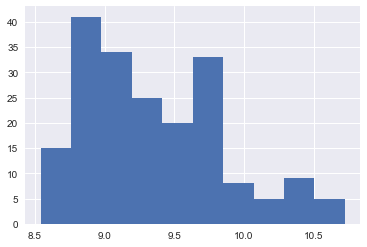

In [41]:
# STUDENT SECTION

cars['log_price']=np.log(cars.price)
# looks better
cars.log_price.hist()

In [42]:
lsm = smf.ols('log_price~ engine_size + curb_weight +horsepower + width + length + wheel_base + bore + height', data = cars)
fit2 = lsm.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     152.3
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           2.07e-77
Time:                        22:12:39   Log-Likelihood:                 52.621
No. Observations:                 195   AIC:                            -87.24
Df Residuals:                     186   BIC:                            -57.79
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.4880      0.845      5.313      0.000       2.821       6.155
engine_size     0.0015      0.001      1.843      0.067      -0.000       0.003
curb_weight     0.0003   8.85e-05      3.870      0.000       0.000       0.001
horsepower      0.0046      0.001      5.873      0.000       0.003       0.006
width           0.0405      0.015      2.666      0.008       0.011       0.071
length          0.0035      0.003      1.065      0.288      -0.003       0.010
wheel_base     -0.0074      0.006     -1.239      0.217      -0.019       0.004
bore            0.0024      0.067      0.035      0.972      -0.131       0.135
height          0.0141      0.008      1.683      0.094      -0.002       0.031
==============================================================================
Omnibus:                       15.467   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.016
Skew:                           0.592   Prob(JB):                     0.000122
Kurtosis:                       3.902   Cond. No.                     1.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
cars['engine_log']=np.log(cars.engine_size)

In [44]:
# we see that the transformed engize-size values have a stronger correlation
cars.corr()['log_price'].sort_values(ascending=False)

log_price            1.000000
price                0.957443
curb_weight          0.894720
engine_log           0.886122
engine_size          0.852747
horsepower           0.833171
width                0.801630
length               0.783528
wheel_base           0.640868
bore                 0.609647
height               0.193275
stroke               0.109640
compression-ratio    0.089332
peak-rpm            -0.116834
city-mpg            -0.785839
highway-mpg         -0.789156
Name: log_price, dtype: float64

In [45]:
# small improvement here
lsm = smf.ols('log_price~ engine_log + curb_weight +horsepower + width + length + wheel_base + bore + height', data = cars)
fit3 = lsm.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     154.4
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           7.04e-78
Time:                        22:12:46   Log-Likelihood:                 53.758
No. Observations:                 195   AIC:                            -89.52
Df Residuals:                     186   BIC:                            -60.06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.2452      0.993      3.268      0.001       1.286       5.204
engine_log      0.3490      0.147      2.370      0.019       0.059       0.640
curb_weight     0.0003   9.04e-05      3.437      0.001       0.000       0.000
horsepower      0.0044      0.001      5.567      0.000       0.003       0.006
width           0.0392      0.015      2.592      0.010       0.009       0.069
length          0.0027      0.003      0.838      0.403      -0.004       0.009
wheel_base     -0.0063      0.006     -1.067      0.287      -0.018       0.005
bore           -0.0239      0.068     -0.350      0.727      -0.158       0.111
height          0.0153      0.008      1.824      0.070      -0.001       0.032
==============================================================================
Omnibus:                       12.306   Durbin-Watson:                   0.834
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.402
Skew:                           0.527   Prob(JB):                      0.00123
Kurtosis:                       3.734   Cond. No.                     1.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

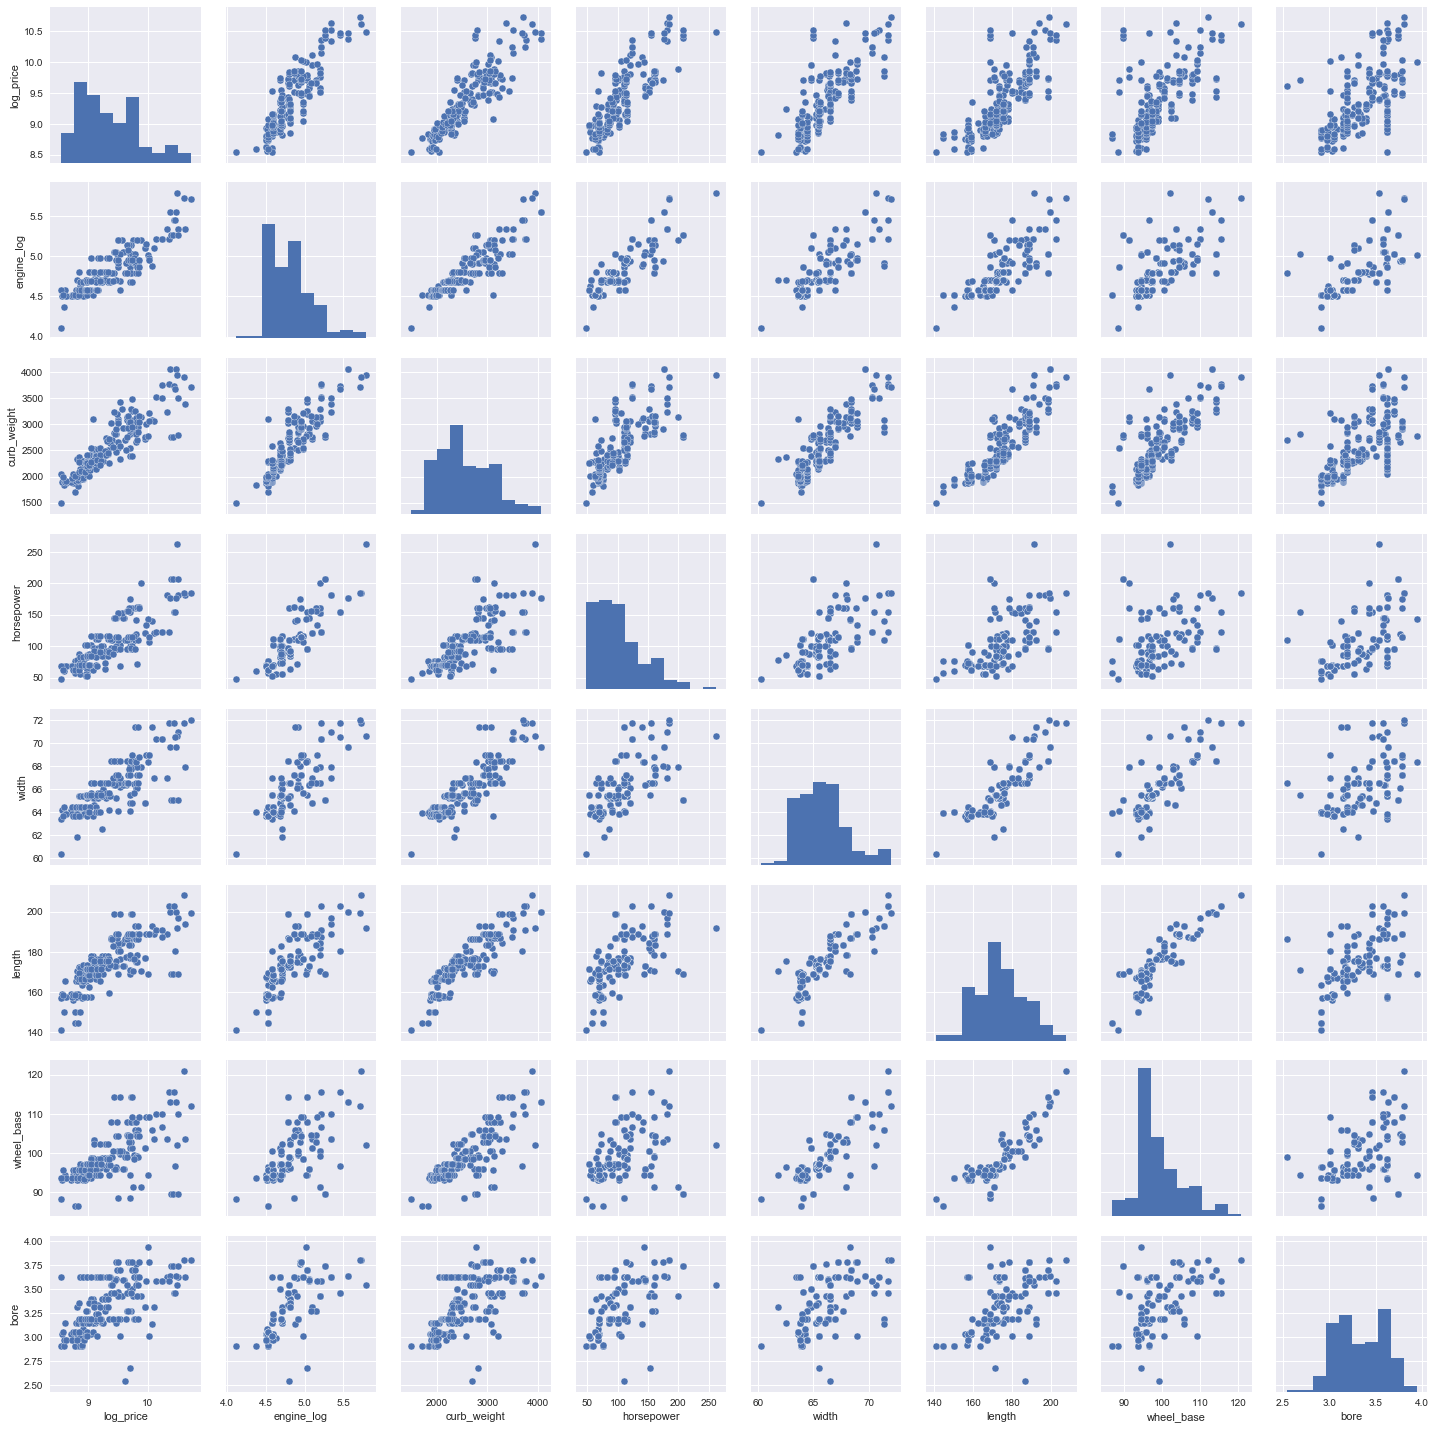

In [46]:
# STUDENT SECTION
#Let's try visualizing some of these pairwise correlations with seaborn
sns.pairplot(cars[['log_price','engine_log', 'curb_weight', 'horsepower', 'width', 'length', 'wheel_base','bore']])

#### What can we do with this observation?
##### Indicator (Dummy) Variables
As a first attempt, let's try to create [***indicator variables***](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) Indicator variables are 0/1 binary variables that indicate whether a condition is met or not, and they are quite useful in regression as they have an easy conceptual understanding: a value of 1 for a given field increases the target variable by the amount of its model coefficient.  These are often useful when provided with categorical attributes.  Any field with n unique categorical values can be reformulated into n indicator variable fields where each represents whether or not that attribute value is present.

Let's see how to transform a categorical variable into a dummy variable..

In [47]:
# Let's add 'make'
print(df.make.value_counts())
print('\n')
print(len(df.make.value_counts()))

toyota           32
nissan           18
mazda            17
mitsubishi       13
honda            13
subaru           12
volkswagen       12
volvo            11
peugot           11
dodge             9
bmw               8
mercedes-benz     8
plymouth          7
audi              7
saab              6
porsche           5
isuzu             4
chevrolet         3
alfa-romero       3
jaguar            3
renault           2
mercury           1
Name: make, dtype: int64


22


In [48]:

# Let's use patsy to convert the feature 'make' to categorical variables

In [49]:
X=patsy.dmatrix('make',data=df,return_type='dataframe')
X.head()

# Q for Students: What do you notice about the returned matrix ? 

Intercept  make[T.audi]  make[T.bmw]  make[T.chevrolet]  make[T.dodge]  \
0        1.0           0.0          0.0                0.0            0.0   
1        1.0           0.0          0.0                0.0            0.0   
2        1.0           0.0          0.0                0.0            0.0   
3        1.0           1.0          0.0                0.0            0.0   
4        1.0           1.0          0.0                0.0            0.0   

   make[T.honda]  make[T.isuzu]  make[T.jaguar]  make[T.mazda]  \
0            0.0            0.0             0.0            0.0   
1            0.0            0.0             0.0            0.0   
2            0.0            0.0             0.0            0.0   
3            0.0            0.0             0.0            0.0   
4            0.0            0.0             0.0            0.0   

   make[T.mercedes-benz]      ...        make[T.nissan]  make[T.peugot]  \
0                    0.0      ...                   0.0             0.0   
1                    0.0      ...                   0.0             0.0   
2                    0.0      ...                   0.0             0.0   
3                    0.0      ...                   0.0             0.0   
4                    0.0      ...                   0.0             0.0   

   make[T.plymouth]  make[T.porsche]  make[T.renault]  make[T.saab]  \
0               0.0              0.0              0.0           0.0   
1               0.0              0.0              0.0           0.0   
2               0.0              0.0              0.0           0.0   
3               0.0              0.0              0.0           0.0   
4               0.0              0.0              0.0           0.0   

   make[T.subaru]  make[T.toyota]  make[T.volkswagen]  make[T.volvo]  
0             0.0             0.0                 0.0            0.0  
1             0.0             0.0                 0.0            0.0  
2             0.0             0.0                 0.0            0.0  
3             0.0             0.0                 0.0            0.0  
4             0.0             0.0                 0.0            0.0  

[5 rows x 22 columns]

In [50]:
# A:  A couple of things:  1) First of all, we've added an intercept (comes for free w/ patsy!)  
#  2) 2nd: our favorite 'make' ('alfo-romero' of course) is missing from the above matrix

## This is because patsy knows about (The Dummy Variable Trap)[http://www.algosome.com/articles/dummy-variable-trap-regression.html]
# The idea behind DVT: Take a categorical variable that has two outcomes (example: boy & girl for the feature 'sex) - 
# We only need one column: "Girl", we can obviously solve for 'Boy' given this column -- if we had 
# both columns, we would automatically introduce multicolinearity  -- this idea can be extended to categorical features with 
# 20+ categories ! 

In [51]:
# STUDENT SECTION
# Append the X matrix to your cars matrix

cars2=cars.join(X)

## Cool thing to note: even though cars & X are different lengths (due to our previous .dropna()) ~ 
# joins allows us to 'merge' on their common index 

In [52]:
## For fun, let's see a quick way to throw cars2 into a OLS model,

# sm (vs smf) allows for the following shortcut!
import statsmodels.api as sm

y = cars2.log_price
x=cars2.drop(['log_price','price'],1)

lsm = sm.OLS(y,x)
fit4 = lsm.fit()
fit4.summary()

#  Looks like 'make' gives our R-squared a boost

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     99.94
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           5.49e-91
Time:                        22:13:35   Log-Likelihood:                 157.93
No. Observations:                 195   AIC:                            -245.9
Df Residuals:                     160   BIC:                            -131.3
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
length                   -0.0007      0.003     -0.271      0.787      -0.006       0.005
width                    -0.0065      0.013     -0.481      0.631      -0.033       0.020
height                   -0.0299      0.007     -4.013      0.000      -0.045      -0.015
bore                      0.0095      0.069      0.138      0.890      -0.126       0.145
stroke                    0.0128      0.055      0.234      0.816      -0.095       0.121
compression-ratio         0.0074      0.004      1.943      0.054      -0.000       0.015
horsepower                0.0028      0.001      3.189      0.002       0.001       0.004
peak-rpm              -2.381e-05   3.48e-05     -0.685      0.495   -9.25e-05    4.49e-05
city-mpg                 -0.0161      0.009     -1.881      0.062      -0.033       0.001
highway-mpg               0.0087      0.007      1.217      0.226      -0.005       0.023
curb_weight               0.0006   8.47e-05      6.658      0.000       0.000       0.001
engine_size               0.0016      0.002      0.843      0.400      -0.002       0.005
wheel_base                0.0129      0.005      2.439      0.016       0.002       0.023
engine_log               -0.3715      0.317     -1.173      0.242      -0.997       0.254
Intercept                10.3592      1.521      6.811      0.000       7.356      13.363
make[T.audi]              0.1234      0.107      1.155      0.250      -0.088       0.334
make[T.bmw]               0.2867      0.093      3.083      0.002       0.103       0.470
make[T.chevrolet]        -0.2056      0.121     -1.693      0.092      -0.445       0.034
make[T.dodge]            -0.3292      0.095     -3.470      0.001      -0.516      -0.142
make[T.honda]            -0.1542      0.099     -1.553      0.123      -0.350       0.042
make[T.isuzu]            -0.3940      0.115     -3.428      0.001      -0.621      -0.167
make[T.jaguar]           -0.3571      0.153     -2.339      0.021      -0.659      -0.056
make[T.mazda]            -0.1191      0.090     -1.324      0.187      -0.297       0.059
make[T.mercedes-benz]     0.0673      0.123      0.547      0.585      -0.176       0.310
make[T.mercury]          -0.2021      0.161     -1.256      0.211      -0.520       0.116
make[T.mitsubishi]       -0.3839      0.089     -4.317      0.000      -0.560      -0.208
make[T.nissan]           -0.2067      0.085     -2.432      0.016      -0.375      -0.039
make[T.peugot]           -0.2832      0.110     -2.572      0.011      -0.501      -0.066
make[T.plymouth]         -0.3467      0.095     -3.632      0.000      -0.535      -0.158
make[T.porsche]           0.4856      0.112      4.340      0.000       0.265       0.707
make[T.renault]        1.628e-15   2.61e-16      6.236      0.000    1.11e-15    2.14e-15
make[T.saab]           